In [360]:
import os 
import sys
import math
import json
import copy

import pickle
import optuna
import logging
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
# from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter
from pyecharts import options as opts
from pyecharts.charts import Graph
from pyecharts.globals import CurrentConfig, NotebookType
from matplotlib.colors import LogNorm, Normalize
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

%matplotlib inline

np.random.seed(2022)
data_folder = '../data/'

# Load the dataset 

In [3]:
original_data = pd.read_csv(os.path.join(data_folder, 'arealstatistik_all_points_only_classes.csv'), index_col=0)
original_data.head()

,EAST,NORTH,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1
RELI,,,,,,,,,,
74222228,2742200,1222800,242,21,242,21,242,21,242,21
76582227,2765800,1222700,301,45,301,45,301,45,301,45
72042228,2720400,1222800,222,21,222,21,222,21,222,21
74632226,2746300,1222600,421,21,421,21,421,21,421,21
75392541,2753900,1254100,301,41,301,41,301,41,301,41


In [4]:
# change the numerical labels to string in case of regression w.r.t. numerical relationship 
pd.set_option('mode.chained_assignment', None)
original_data[['LU1', 'LU2', 'LU3', 'LU4']] = original_data[['LU1', 'LU2', 'LU3', 'LU4']].astype('str')
original_data[['LC1', 'LC2', 'LC3', 'LC4']] = original_data[['LC1', 'LC2', 'LC3', 'LC4']].astype('str')

original_data.head()

,EAST,NORTH,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1
RELI,,,,,,,,,,
74222228,2742200,1222800,242,21,242,21,242,21,242,21
76582227,2765800,1222700,301,45,301,45,301,45,301,45
72042228,2720400,1222800,222,21,222,21,222,21,222,21
74632226,2746300,1222600,421,21,421,21,421,21,421,21
75392541,2753900,1254100,301,41,301,41,301,41,301,41


# Distribution analysis 

In [5]:
data_cover = original_data[['LC4', 'LC3', 'LC2', 'LC1']]
data_cover.head()

,LC4,LC3,LC2,LC1
RELI,,,,
74222228,21,21,21,21
76582227,45,45,45,45
72042228,21,21,21,21
74632226,21,21,21,21
75392541,41,41,41,41


In [6]:
data_use = original_data[['LU4', 'LU3', 'LU2', 'LU1']]

data_use.head()

,LU4,LU3,LU2,LU1
RELI,,,,
74222228,242,242,242,242
76582227,301,301,301,301
72042228,222,222,222,222
74632226,421,421,421,421
75392541,301,301,301,301


In [7]:
plot_use = pd.melt(data_use, var_name='survey', value_name='label')
plot_cover = pd.melt(data_cover, var_name='survey', value_name='label')
plot_use.label = pd.Categorical(plot_use.label.values, ordered=True)
plot_cover.label = pd.Categorical(plot_cover.label.values, ordered=True)

In [8]:
plot_cover.head()

,survey,label
0,LC4,21
1,LC4,45
2,LC4,21
3,LC4,21
4,LC4,41


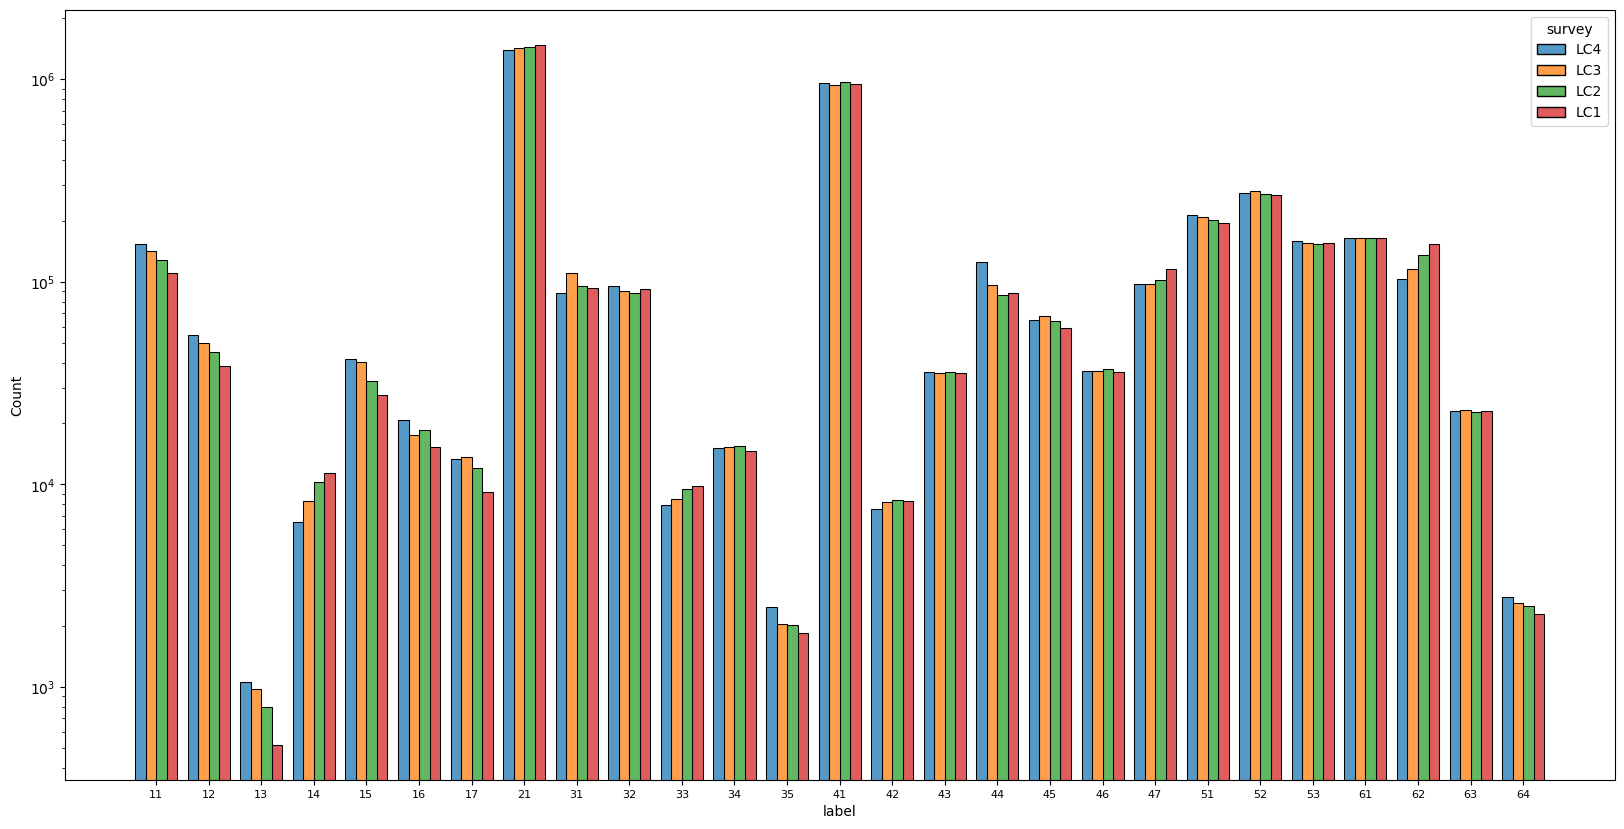

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
sn.histplot(plot_cover,x='label',hue='survey', log_scale=[False,True], multiple='dodge',shrink=.8, ax=ax)
plt.xticks(fontsize=8)
plt.show()

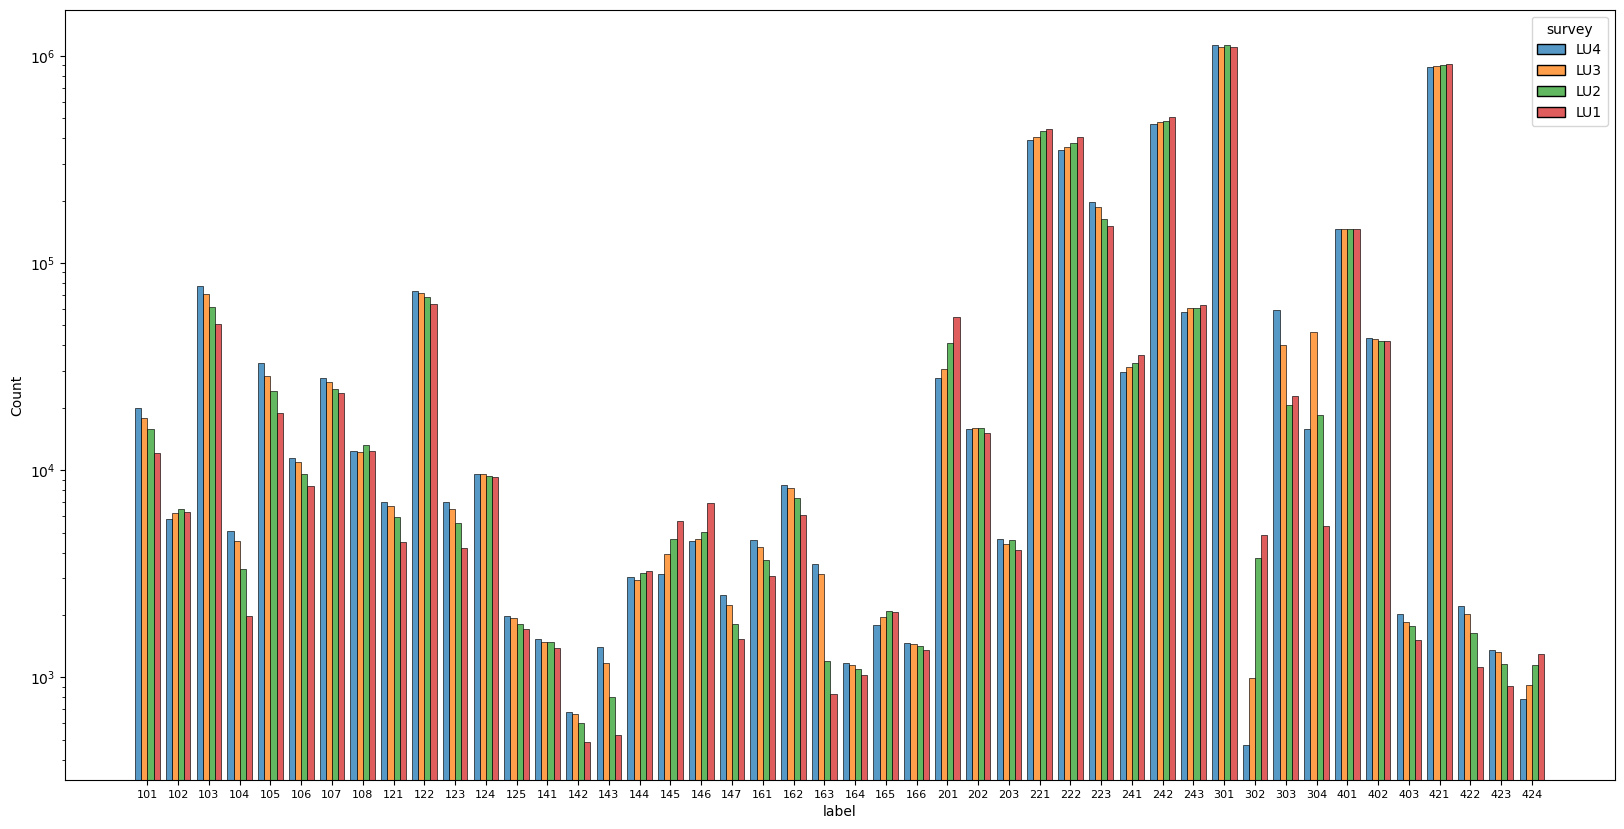

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
sn.histplot(plot_use,x='label',hue='survey', log_scale=[False,True], multiple='dodge',shrink=.8, ax=ax)
plt.xticks(fontsize=8)
plt.show()

In [11]:
land_cover = pd.read_csv(os.path.join(data_folder, 'Land_Cover_04_label.csv'), index_col=0)
land_cover.head()

,Principal_domain,Basic_category,Label
11,Artificial_areas,Consolidated_surfaces,LC11
12,Artificial_areas,Buildings,LC12
13,Artificial_areas,Greenhouses,LC13
14,Artificial_areas,Gardens_with_border_and_patch_structures,LC14
15,Artificial_areas,Lawns,LC15


In [200]:
land_use = pd.read_csv(os.path.join(data_folder, 'Land_Usage_04_label.csv'), index_col=0)
land_use.head()

,Principal_domain,classes,Basic_category,Label
101,Settlement_and_urban areas,Building_areas,Industrial_and_commercial_areas_greater_than_1_ha,LU101
102,Settlement_and_urban areas,Building_areas,Industrial_and_commercial_areas_less_than_1_ha,LU102
103,Settlement_and_urban areas,Building_areas,Residential_areas_one_and_two-family_houses,LU103
104,Settlement_and_urban areas,Building_areas,Residential_areas_terraced_houses,LU104
105,Settlement_and_urban areas,Building_areas,Residential_areas_blocks_of_flats,LU105


# Transformation Plot 

## Land Cover

In [13]:
edge_LC1_LC2 = []
edge_LC2_LC3 = []
edge_LC3_LC4 = []
edge_all = []

for ind, row in data_cover.iterrows():
    if row.LC1 != row.LC2:
        edge_LC1_LC2.append((row.LC1, row.LC2))
    if row.LC2 != row.LC3:
        edge_LC2_LC3.append((row.LC2, row.LC3))
    if row.LC3 != row.LC4:
        edge_LC3_LC4.append((row.LC3, row.LC4))    

In [14]:
edge_all = edge_LC1_LC2 + edge_LC2_LC3 + edge_LC3_LC4

In [47]:
len(edge_all)

1022006

In [43]:
# set up a filtering thred to remove minority transformations
filter_thred = 0.001

weighted_edge_LC1_LC2 = []
weighted_edge_LC2_LC3 = []
weighted_edge_LC3_LC4 = []
weighted_edge_all = []

for edge,w in Counter(edge_LC1_LC2).items():
    if w >= filter_thred * len(edge_LC1_LC2):
        weighted_edge_LC1_LC2.append((edge[0], edge[1], w))
        
for edge,w in Counter(edge_LC2_LC3).items():
    if w >= filter_thred * len(edge_LC2_LC3):
        weighted_edge_LC2_LC3.append((edge[0], edge[1], w))
        
for edge,w in Counter(edge_LC3_LC4).items():
    if w >= filter_thred * len(edge_LC3_LC4):
        weighted_edge_LC3_LC4.append((edge[0], edge[1], w))
        
for edge,w in Counter(edge_all).items():
    if w >= filter_thred * len(edge_all):
        weighted_edge_all.append((edge[0], edge[1], w))

In [18]:
len(weighted_edge_LC1_LC2)

548

In [20]:
weighted_edge_LC1_LC2[:5]

[('47', '21', 16113),
 ('21', '44', 1469),
 ('21', '53', 1164),
 ('21', '15', 5487),
 ('33', '21', 1691)]

In [46]:
len(weighted_edge_all)

112

In [17]:
land_cover.Principal_domain = pd.Categorical(land_cover.Principal_domain, ordered=True, 
                                             categories=['Artificial_areas', 'Grass_and_herb_vegetation', 'Brush_vegetation','Tree_vegetation', 'Bare_land', 'Watery areas'])
land_cover['Principal_domain_ind'] = land_cover.Principal_domain.cat.codes
land_cover

,Principal_domain,Basic_category,Label,Principal_domain_ind
11,Artificial_areas,Consolidated_surfaces,LC11,0
12,Artificial_areas,Buildings,LC12,0
13,Artificial_areas,Greenhouses,LC13,0
14,Artificial_areas,Gardens_with_border_and_patch_structures,LC14,0
15,Artificial_areas,Lawns,LC15,0
16,Artificial_areas,Trees_in_artificial_areas,LC16,0
17,Artificial_areas,Mix_of_small_structures,LC17,0
21,Grass_and_herb_vegetation,Grass_and_herb_vegetation,LC21,1
31,Brush_vegetation,Shrubs,LC31,2
32,Brush_vegetation,Brush_meadows,LC32,2


In [256]:
counter = Counter(data_cover.LC4)
count_max = max(counter.values())
count_min = min(counter.values())
print(count_max,count_min)

1398096 1057


In [33]:
# count the change occurrence and normalize 
counter = Counter(data_cover.LC4)
count_max = max(counter.values())
for k, v in counter.items():
    # counter[k] = v/count_max * 100
    counter[k] = np.log2(v/10)

# create the df and sort by index 
df_size = pd.DataFrame.from_dict(counter, orient='index')
df_size.rename(columns={0:'size'}, inplace=True)
df_size.sort_index(inplace=True)
df_size.head()

,size
11,13.912188
12,12.414210
13,6.723832
14,9.351823
15,12.020390


In [34]:
land_cover['symbolSize'] = df_size['size'].values
land_cover

,Principal_domain,Basic_category,Label,Principal_domain_ind,symbolSize
11,Artificial_areas,Consolidated_surfaces,LC11,0,13.912188
12,Artificial_areas,Buildings,LC12,0,12.414210
13,Artificial_areas,Greenhouses,LC13,0,6.723832
14,Artificial_areas,Gardens_with_border_and_patch_structures,LC14,0,9.351823
15,Artificial_areas,Lawns,LC15,0,12.020390
16,Artificial_areas,Trees_in_artificial_areas,LC16,0,11.016251
17,Artificial_areas,Mix_of_small_structures,LC17,0,10.380461
21,Grass_and_herb_vegetation,Grass_and_herb_vegetation,LC21,1,17.093104
31,Brush_vegetation,Shrubs,LC31,2,13.105008
32,Brush_vegetation,Brush_meadows,LC32,2,13.222508


In [20]:
land_cover[['Principal_domain_ind','Principal_domain']].drop_duplicates()

,Principal_domain_ind,Principal_domain
11,0,Artificial_areas
21,1,Grass_and_herb_vegetation
31,2,Brush_vegetation
41,3,Tree_vegetation
51,4,Bare_land
61,5,Watery areas


In [24]:
links = []
for row in weighted_edge_LC1_LC2:
    # jsontext['links'].append(
    links.append(
         opts.GraphLink(
           source = row[0],
           target = row[1],
           value = row[2],
           # linestyle_opts=opts.LineStyleOpts(width=2, color="source", curve=0.3)
           linestyle_opts=opts.LineStyleOpts(width=row[2]/2000, color="source", curve=0.3)
       )
    )

In [49]:
# init the json file
jsontext = {
    'categories':[],
    'nodes':[]
    }

# categories = []
links = []
# nodes =[]
# create the json file with given data
for ind, row in land_cover[['Principal_domain_ind','Principal_domain']].drop_duplicates().iterrows():
    jsontext['categories'].append({'name':row['Principal_domain']})

for ind, row in land_cover.iterrows():
    jsontext['nodes'].append(
    # nodes.append(
        {'id': ind,
         'name': row['Basic_category'],
         'symbolSize': row['symbolSize'],
         # 'x': -266.82776,
         # 'y': 299.6904,
         'value': ind,
         'label': {'normal': {'show': True}},
         'category':  row['Principal_domain_ind']})

    
# save the file 
jsondata = json.dumps(jsontext,indent=4,separators=(',', ': '))
f = open('nodes.json', 'w')
f.write(jsondata)
f.close()

In [25]:
# render the html plot
with open("nodes.json", "r", encoding="utf-8") as f:
    j = json.load(f)
    nodes = j["nodes"]
    # links = j["links"]
    categories = j["categories"]

c = (
    Graph(init_opts=opts.InitOpts(width="1000px", height="1000px"))
    .add(
        "",
        nodes=nodes,
        links=links,
        categories=categories,
        layout="circular",
        is_rotate_label=True,
        edge_symbol=['circle', 'arrow'],
        edge_symbol_size=[0, 10]
        linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
        label_opts=opts.LabelOpts(position="right"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="LC1 --> LC2 transformation"),
        legend_opts=opts.LegendOpts(orient="vertical", pos_left="2%", pos_top="20%"),
    )
    .render("test_LC1_LC2.html")
)

## Land Use

In [179]:
edge_LU1_LU2 = []
edge_LU2_LU3 = []
edge_LU3_LU4 = []
edge_all = []

for ind, row in data_use.iterrows():
    if row.LU1 != row.LU2:
        edge_LU1_LU2.append((row.LU1, row.LU2))
    if row.LU2 != row.LU3:
        edge_LU2_LU3.append((row.LU2, row.LU3))
    if row.LU3 != row.LU4:
        edge_LU3_LU4.append((row.LU3, row.LU4))    

In [180]:
edge_all = edge_LU1_LU2 + edge_LU2_LU3 + edge_LU3_LU4

In [181]:
filter_thred = 0.001

weighted_edge_LU1_LU2 = []
weighted_edge_LU2_LU3 = []
weighted_edge_LU3_LU4 = []
weighted_edge_all = []

for edge,w in Counter(edge_LU1_LU2).items():
    if w >= filter_thred * len(edge_LU1_LU2):
        weighted_edge_LU1_LU2.append((edge[0], edge[1], w))
        
for edge,w in Counter(edge_LU2_LU3).items():
    if w >= filter_thred * len(edge_LU2_LU3):
        weighted_edge_LU2_LU3.append((edge[0], edge[1], w))
        
for edge,w in Counter(edge_LU3_LU4).items():
    if w >= filter_thred * len(edge_LU3_LU4):
        weighted_edge_LU3_LU4.append((edge[0], edge[1], w))
        
for edge,w in Counter(edge_all).items():
    if w >= filter_thred * len(edge_all):
        weighted_edge_all.append((edge[0], edge[1], w))

In [182]:
len(weighted_edge_all)

86

In [183]:
len(edge_all)

879501

In [184]:
weighted_edge_LU1_LU2[:5]

[('223', '222', 6007),
 ('222', '223', 18804),
 ('201', '223', 4047),
 ('223', '201', 596),
 ('201', '222', 6647)]

In [202]:
land_use.classes = pd.Categorical(land_use.classes, ordered=True, 
                                             categories=['Building_areas', 'Transport_surfaces', 'Special_urban_areas',
                                                         'Recreational_areas_and_cemeteries', 'Orchards_vineyards_horticulture', 
                                                         'Arable_and_Grassland', 'Alpine_grazing_areas', 'Forest_not_agricultural', 
                                                         'Lakes_and_rivers', 'Unproductive_land'])
land_use['classes_ind'] = land_use.classes.cat.codes
land_use

,Principal_domain,classes,Basic_category,Label,classes_ind
101,Settlement_and_urban areas,Building_areas,Industrial_and_commercial_areas_greater_than_1_ha,LU101,0
102,Settlement_and_urban areas,Building_areas,Industrial_and_commercial_areas_less_than_1_ha,LU102,0
103,Settlement_and_urban areas,Building_areas,Residential_areas_one_and_two-family_houses,LU103,0
104,Settlement_and_urban areas,Building_areas,Residential_areas_terraced_houses,LU104,0
105,Settlement_and_urban areas,Building_areas,Residential_areas_blocks_of_flats,LU105,0
106,Settlement_and_urban areas,Building_areas,Public_buildings_and_surroundings,LU106,0
107,Settlement_and_urban areas,Building_areas,Agricultural_buildings_and_surroundings,LU107,0
108,Settlement_and_urban areas,Building_areas,Unspecified_buildings_and_surroundings,LU108,0
121,Settlement_and_urban areas,Transport_surfaces,Motorways,LU121,1
122,Settlement_and_urban areas,Transport_surfaces,Roads,LU122,1


In [204]:
counter = Counter(data_use.LU4)
count_max = max(counter.values())
count_min = min(counter.values())
print(count_max,count_min)

1129891 473


In [237]:
# count the change occurrence and normalize 
counter = Counter(data_use.LU4)
count_max = max(counter.values())
for k, v in counter.items():
    # counter[k] = v/count_max * 100
    counter[k] = np.log10(v/100) * 5

# create the df and sort by index 
df_size = pd.DataFrame.from_dict(counter, orient='index')
df_size.rename(columns={0:'size'}, inplace=True)
df_size.sort_index(inplace=True)
df_size.head()

,size
101,11.503738
102,8.821254
103,14.441010
104,8.526752
105,12.579237


In [238]:
land_use['symbolSize'] = df_size['size'].values
land_use.Basic_category = [cat.replace('_', ' ') for cat in land_use.Basic_category]
land_use

,Principal_domain,classes,Basic_category,Label,classes_ind,symbolSize
101,Settlement_and_urban areas,Building_areas,Industrial and commercial areas greater than 1 ha,LU101,0,11.503738
102,Settlement_and_urban areas,Building_areas,Industrial and commercial areas less than 1 ha,LU102,0,8.821254
103,Settlement_and_urban areas,Building_areas,Residential areas one and two-family houses,LU103,0,14.441010
104,Settlement_and_urban areas,Building_areas,Residential areas terraced houses,LU104,0,8.526752
105,Settlement_and_urban areas,Building_areas,Residential areas blocks of flats,LU105,0,12.579237
106,Settlement_and_urban areas,Building_areas,Public buildings and surroundings,LU106,0,10.286999
107,Settlement_and_urban areas,Building_areas,Agricultural buildings and surroundings,LU107,0,12.231054
108,Settlement_and_urban areas,Building_areas,Unspecified buildings and surroundings,LU108,0,10.462726
121,Settlement_and_urban areas,Transport_surfaces,Motorways,LU121,1,9.228900
122,Settlement_and_urban areas,Transport_surfaces,Roads,LU122,1,14.330993


In [239]:
land_use[['classes_ind','classes']].drop_duplicates()

,classes_ind,classes
101,0,Building_areas
121,1,Transport_surfaces
141,2,Special_urban_areas
161,3,Recreational_areas_and_cemeteries
201,4,Orchards_vineyards_horticulture
221,5,Arable_and_Grassland
241,6,Alpine_grazing_areas
301,7,Forest_not_agricultural
401,8,Lakes_and_rivers
421,9,Unproductive_land


In [259]:
links = []
for row in weighted_edge_LU3_LU4:
    # jsontext['links'].append(
    links.append(
         opts.GraphLink(
           source = row[0],
           target = row[1],
           value = row[2],
           # linestyle_opts=opts.LineStyleOpts(width=2, color="source", curve=0.3)
           linestyle_opts=opts.LineStyleOpts(width=row[2]/2000, color="source", curve=0.3)
       )
    )

In [241]:
# init the json file
jsontext = {
    'categories':[],
    'nodes':[]
    }

# create the json file with given data
for ind, row in land_use[['classes_ind','classes']].drop_duplicates().iterrows():
    jsontext['categories'].append({'name':row['classes']})

for ind, row in land_use.iterrows():
    jsontext['nodes'].append(
    # nodes.append(
        {'id': ind,
         'name': row['Basic_category'],
         'symbolSize': row['symbolSize'],
         # 'x': -266.82776,
         # 'y': 299.6904,
         'value': ind,
         'label': {'normal': {'show': True}},
         'category':  row['classes_ind']})

    
# save the file 
jsondata = json.dumps(jsontext,indent=4,separators=(',', ': '))
f = open('LU_nodes.json', 'w')
f.write(jsondata)
f.close()

In [263]:
# render the html plot
with open("LU_nodes.json", "r", encoding="utf-8") as f:
    j = json.load(f)
    nodes = j["nodes"]
    # links = j["links"]
    categories = j["categories"]

c = (
    Graph(init_opts=opts.InitOpts(width="2000px", height="1000px"))
    .add(
        "",
        nodes=nodes,
        links=links,
        categories=categories,
        layout="circular",
        is_rotate_label=True,
        edge_symbol=['circle', 'arrow'],
        edge_symbol_size=[0, 10],
        linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
        label_opts=opts.LabelOpts(position="right"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="LU3 --> LU4 transformation"),
        legend_opts=opts.LegendOpts(orient="vertical", pos_left="2%", pos_top="20%"),
    )
    .render("test_LU3_LU4_arrow.html")
)

# Martrix Plot

## Land Cover

In [401]:
data_cover.head()

,LC4,LC3,LC2,LC1
RELI,,,,
74222228,21,21,21,21
76582227,45,45,45,45
72042228,21,21,21,21
74632226,21,21,21,21
75392541,41,41,41,41


In [402]:
df_LC1_2 = data_cover.groupby(['LC1', 'LC2'])['LC3'].count()
df_LC2_3 = data_cover.groupby(['LC2', 'LC3'])['LC4'].count()
df_LC3_4 = data_cover.groupby(['LC3', 'LC4'])['LC1'].count()
df_LC1_4 = data_cover.groupby(['LC1', 'LC4'])['LC2'].count()

In [403]:
sum_LC1 = data_cover.groupby('LC1')['LC2'].count()
sum_LC2 = data_cover.groupby('LC2')['LC3'].count()
sum_LC3 = data_cover.groupby('LC3')['LC4'].count()

In [404]:
survey_ls = [[sum_LC1, df_LC1_2], [sum_LC2, df_LC2_3], [sum_LC3, df_LC3_4],[sum_LC1, df_LC1_4]]
proba_mat_df_ls = []
for s, df in survey_ls:
    sum_survey = s
    df_survey = df
    proba_mat = []
    for row in sum_survey.index.values:
        proba_row = []
        for col in sum_survey.index.values:
            if (row, col) in df_survey.index:
                proba_row.append(df_survey.loc[(row, col)] / sum_survey[row]) 
            else:
                proba_row.append(0)
        proba_mat.append(proba_row)
    proba_mat_df_ls.append(pd.DataFrame(proba_mat, columns=sum_survey.index.values, index=sum_survey.index.values))

In [405]:
proba_mat_df_ls[0]

,11,12,13,14,15,16,17,21,31,32,...,45,46,47,51,52,53,61,62,63,64
11,0.971657,0.012002,0.000045,0.000153,0.003142,0.000810,0.000999,0.006492,0.000594,0.000351,...,0.000009,0.000198,0.000306,0.000000,0.002161,0.000369,0.000063,0.000000,0.000018,0.000000
12,0.015201,0.971862,0.000000,0.000156,0.002993,0.000521,0.000755,0.004113,0.000312,0.000338,...,0.000000,0.000078,0.000469,0.000000,0.002759,0.000286,0.000000,0.000000,0.000000,0.000000
13,0.019268,0.021195,0.747592,0.042389,0.026975,0.005780,0.007707,0.092486,0.001927,0.001927,...,0.000000,0.001927,0.000000,0.000000,0.015414,0.005780,0.001927,0.000000,0.000000,0.000000
14,0.040961,0.020174,0.005701,0.745987,0.064380,0.023507,0.025436,0.047189,0.001316,0.003158,...,0.000000,0.001228,0.007543,0.000000,0.006754,0.000877,0.000175,0.000000,0.000175,0.000000
15,0.038837,0.010308,0.000036,0.005662,0.802004,0.095387,0.036079,0.004428,0.000254,0.000181,...,0.000000,0.000799,0.000762,0.000000,0.003993,0.000290,0.000145,0.000000,0.000218,0.000000
16,0.026295,0.010479,0.000000,0.004426,0.065933,0.867482,0.019396,0.001106,0.000391,0.000065,...,0.000000,0.000846,0.000260,0.000000,0.002473,0.000065,0.000065,0.000000,0.000065,0.000000
17,0.033089,0.006989,0.000218,0.002403,0.029158,0.098285,0.824506,0.001310,0.000109,0.000218,...,0.000000,0.000328,0.000546,0.000000,0.001966,0.000328,0.000000,0.000000,0.000000,0.000000
21,0.007614,0.002760,0.000181,0.000713,0.003701,0.000442,0.001192,0.953340,0.003177,0.009439,...,0.000173,0.001449,0.006313,0.000011,0.003700,0.000785,0.000134,0.000000,0.000121,0.000015
31,0.001941,0.000536,0.000000,0.000054,0.000440,0.000225,0.000225,0.004901,0.619107,0.002874,...,0.049232,0.007003,0.023463,0.000054,0.003603,0.000794,0.000708,0.000000,0.000054,0.000021
32,0.002846,0.000880,0.000000,0.000174,0.001086,0.000272,0.000510,0.017660,0.125553,0.713119,...,0.028760,0.005322,0.029086,0.000033,0.003399,0.001564,0.000174,0.000000,0.000141,0.000043


In [406]:
np.diagonal(proba_mat_df_ls[0])

array([0.97165675, 0.97186215, 0.74759152, 0.74598719, 0.80200356,
       0.86748243, 0.82450584, 0.95333954, 0.61910736, 0.71311894,
       0.7254902 , 0.94636749, 0.64099783, 0.95724325, 0.83878364,
       0.87812843, 0.72368748, 0.94577253, 0.87158432, 0.68727071,
       0.99835325, 0.9345336 , 0.93925072, 0.98814725, 0.8768001 ,
       0.96889062, 0.95527573])

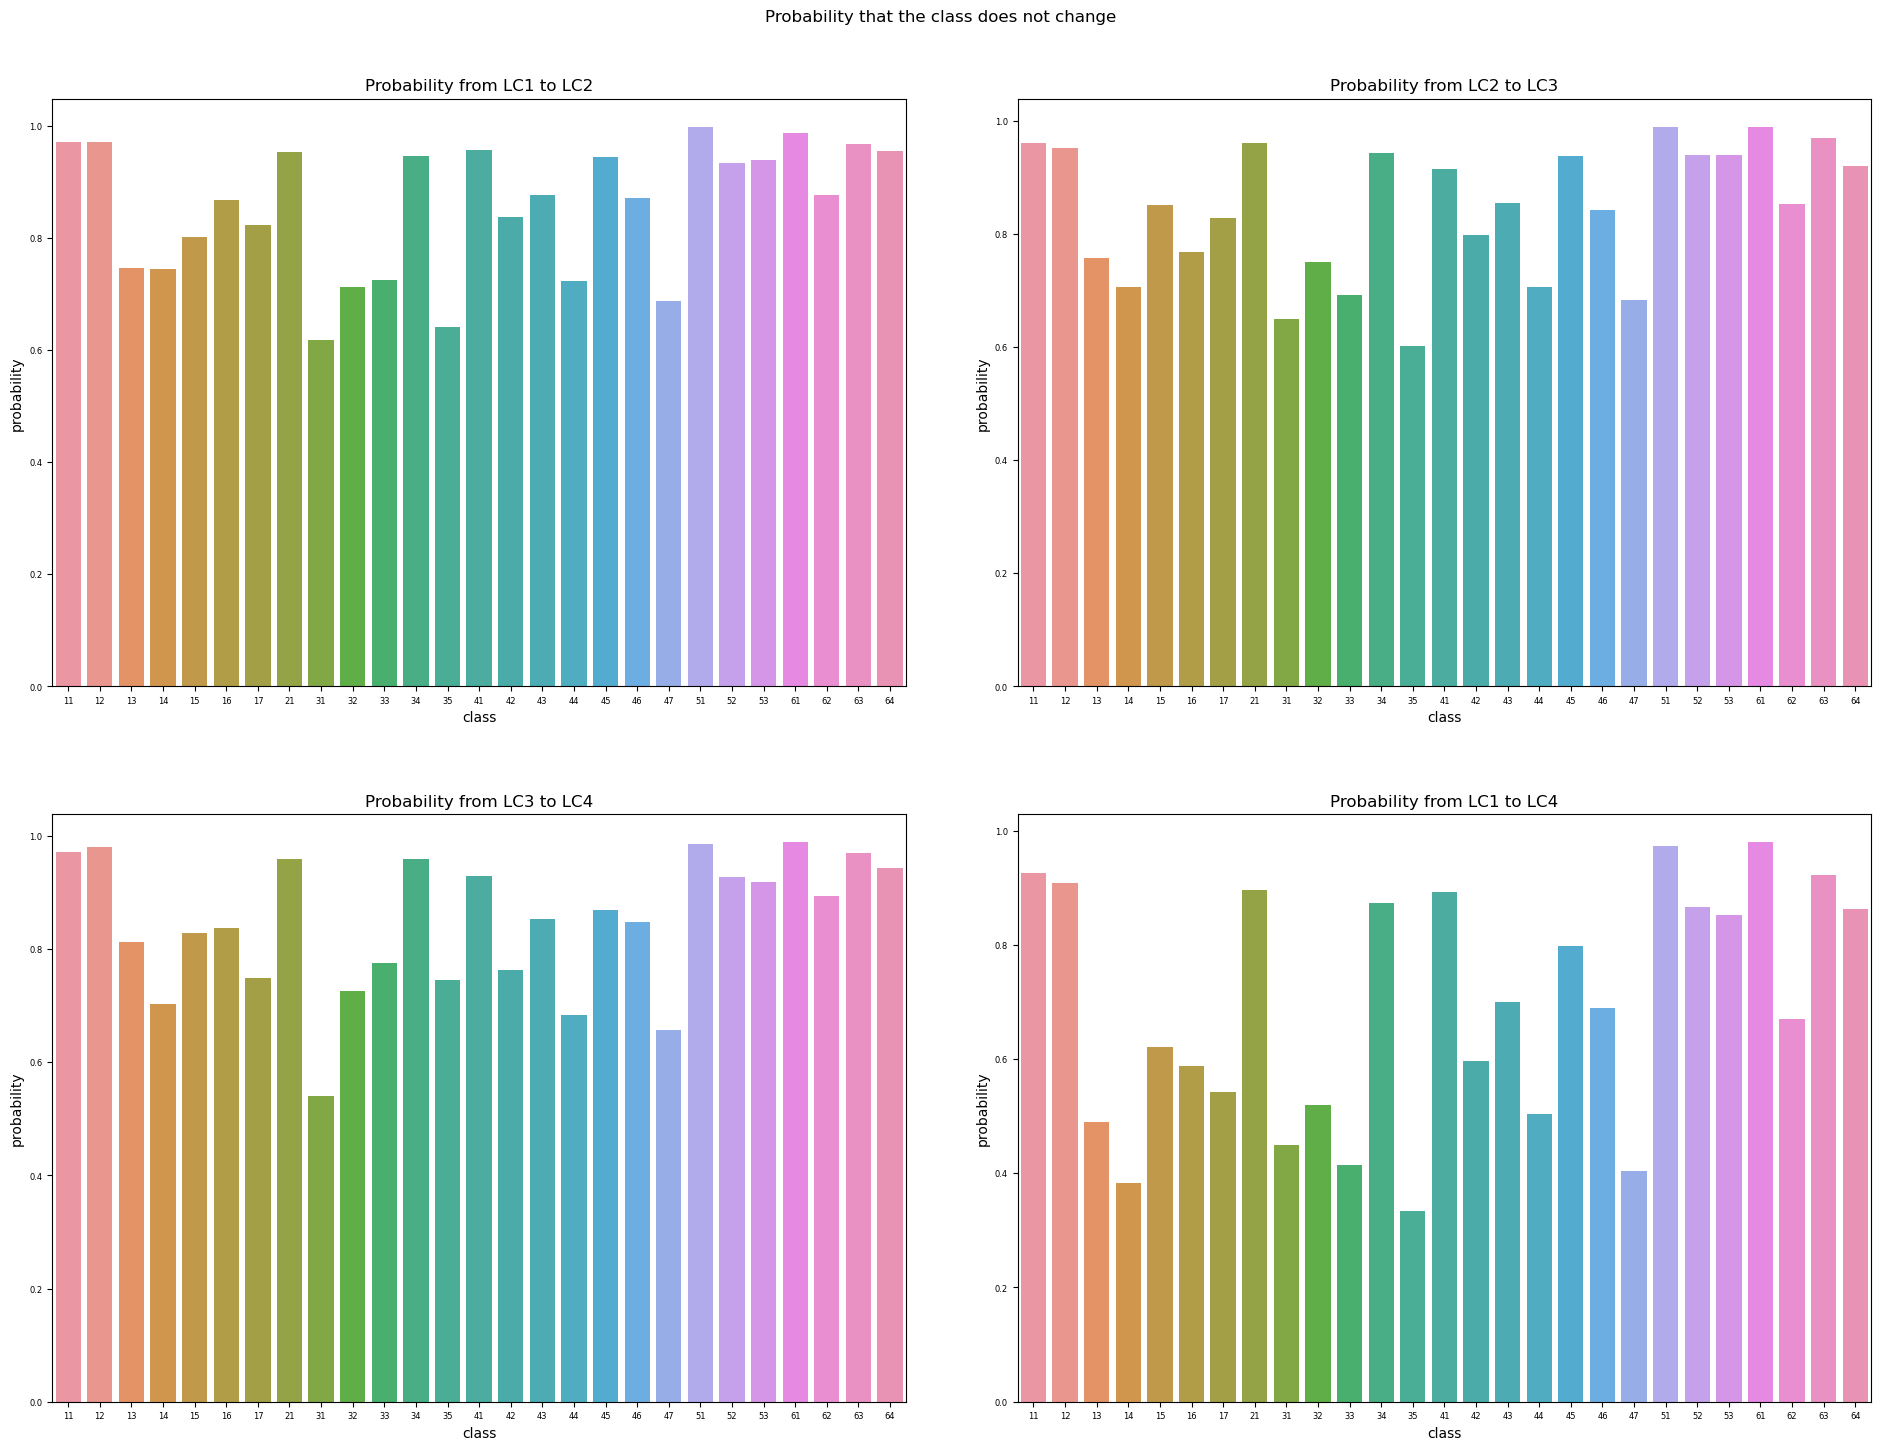

In [408]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
sns.barplot(x=proba_mat_df_ls[0].index, y=np.diagonal(proba_mat_df_ls[0]), ax=ax[0,0])
ax[0,0].set_title('Probability from LC1 to LC2')
ax[0,0].set_xlabel('class')
ax[0,0].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls[1].index, y=np.diagonal(proba_mat_df_ls[1]), ax=ax[0,1])
ax[0,1].set_title('Probability from LC2 to LC3')
ax[0,1].set_xlabel('class')
ax[0,1].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls[2].index, y=np.diagonal(proba_mat_df_ls[2]), ax=ax[1,0])
ax[1,0].set_title('Probability from LC3 to LC4')
ax[1,0].set_xlabel('class')
ax[1,0].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls[3].index, y=np.diagonal(proba_mat_df_ls[3]), ax=ax[1,1])
ax[1,1].set_title('Probability from LC1 to LC4')
ax[1,1].set_xlabel('class')
ax[1,1].set_ylabel('probability')
fig.tight_layout(pad=5)
fig.suptitle("Probability that the class does not change",x=0.5,y=1)
plt.savefig('LC_proba_not_change.png', dpi=200)
plt.show()

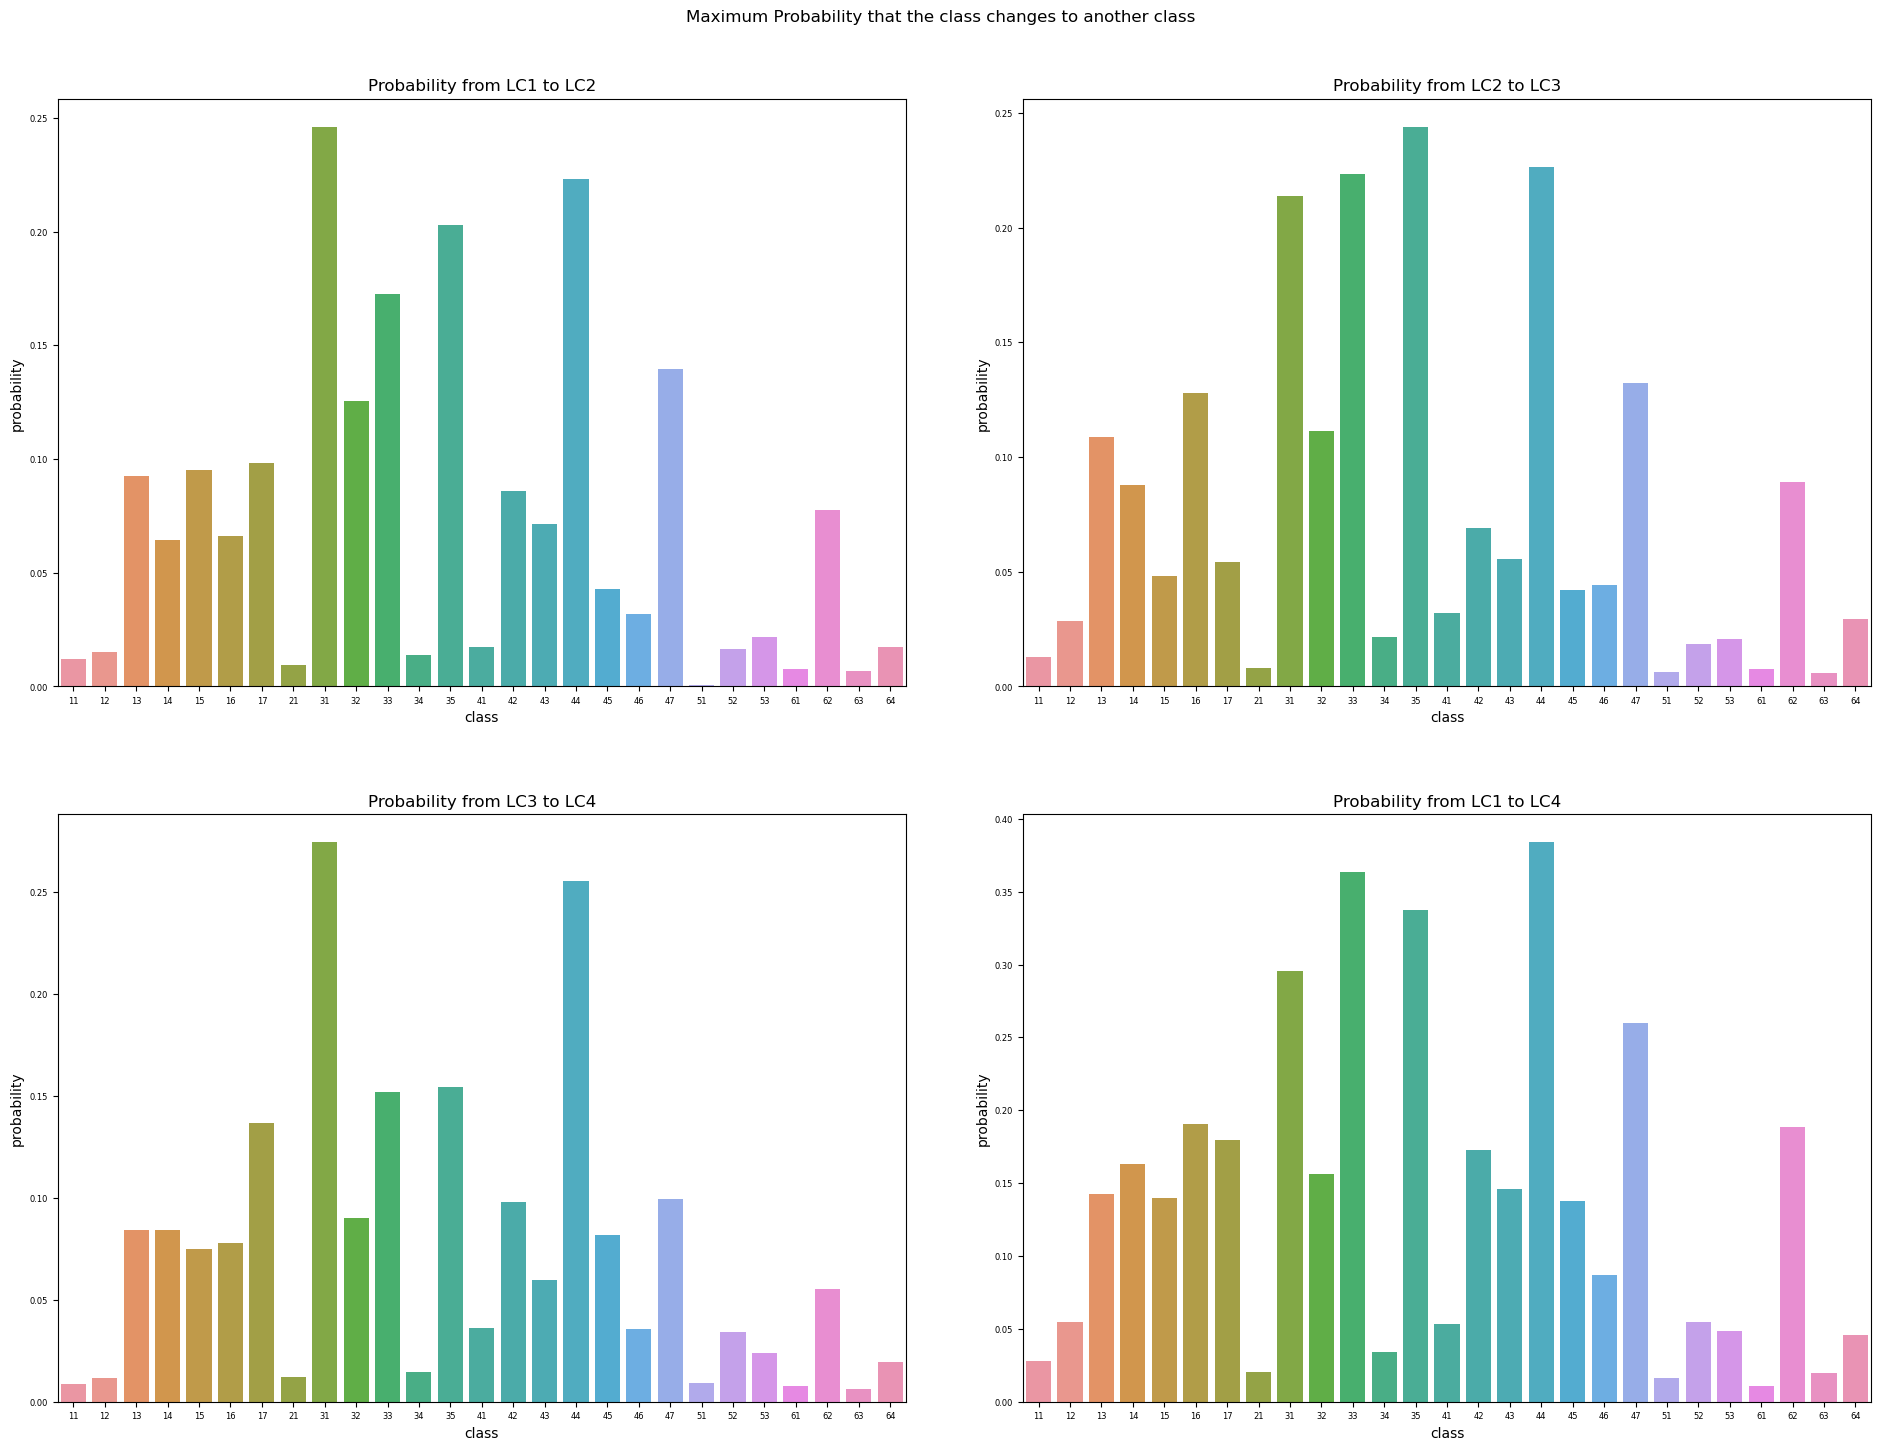

In [409]:
proba_mat_df_ls_copy = copy.deepcopy(proba_mat_df_ls)
np.fill_diagonal(proba_mat_df_ls_copy[0].values, 0)
np.fill_diagonal(proba_mat_df_ls_copy[1].values, 0)
np.fill_diagonal(proba_mat_df_ls_copy[2].values, 0)
np.fill_diagonal(proba_mat_df_ls_copy[3].values, 0)


fig, ax = plt.subplots(2,2, figsize=(20,15))
sns.barplot(x=proba_mat_df_ls_copy[0].index, y=proba_mat_df_ls_copy[0].max(axis=1).values, ax=ax[0,0])
ax[0,0].set_title('Probability from LC1 to LC2')
ax[0,0].set_xlabel('class')
ax[0,0].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls_copy[1].index, y=proba_mat_df_ls_copy[1].max(axis=1).values, ax=ax[0,1])
ax[0,1].set_title('Probability from LC2 to LC3')
ax[0,1].set_xlabel('class')
ax[0,1].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls_copy[2].index, y=proba_mat_df_ls_copy[2].max(axis=1).values, ax=ax[1,0])
ax[1,0].set_title('Probability from LC3 to LC4')
ax[1,0].set_xlabel('class')
ax[1,0].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls_copy[3].index, y=proba_mat_df_ls_copy[3].max(axis=1).values, ax=ax[1,1])
ax[1,1].set_title('Probability from LC1 to LC4')
ax[1,1].set_xlabel('class')
ax[1,1].set_ylabel('probability')
fig.tight_layout(pad=5)
fig.suptitle("Maximum Probability that the class changes to another class",x=0.5,y=1)
plt.savefig('LC_proba_change.png', dpi=200)
plt.show()

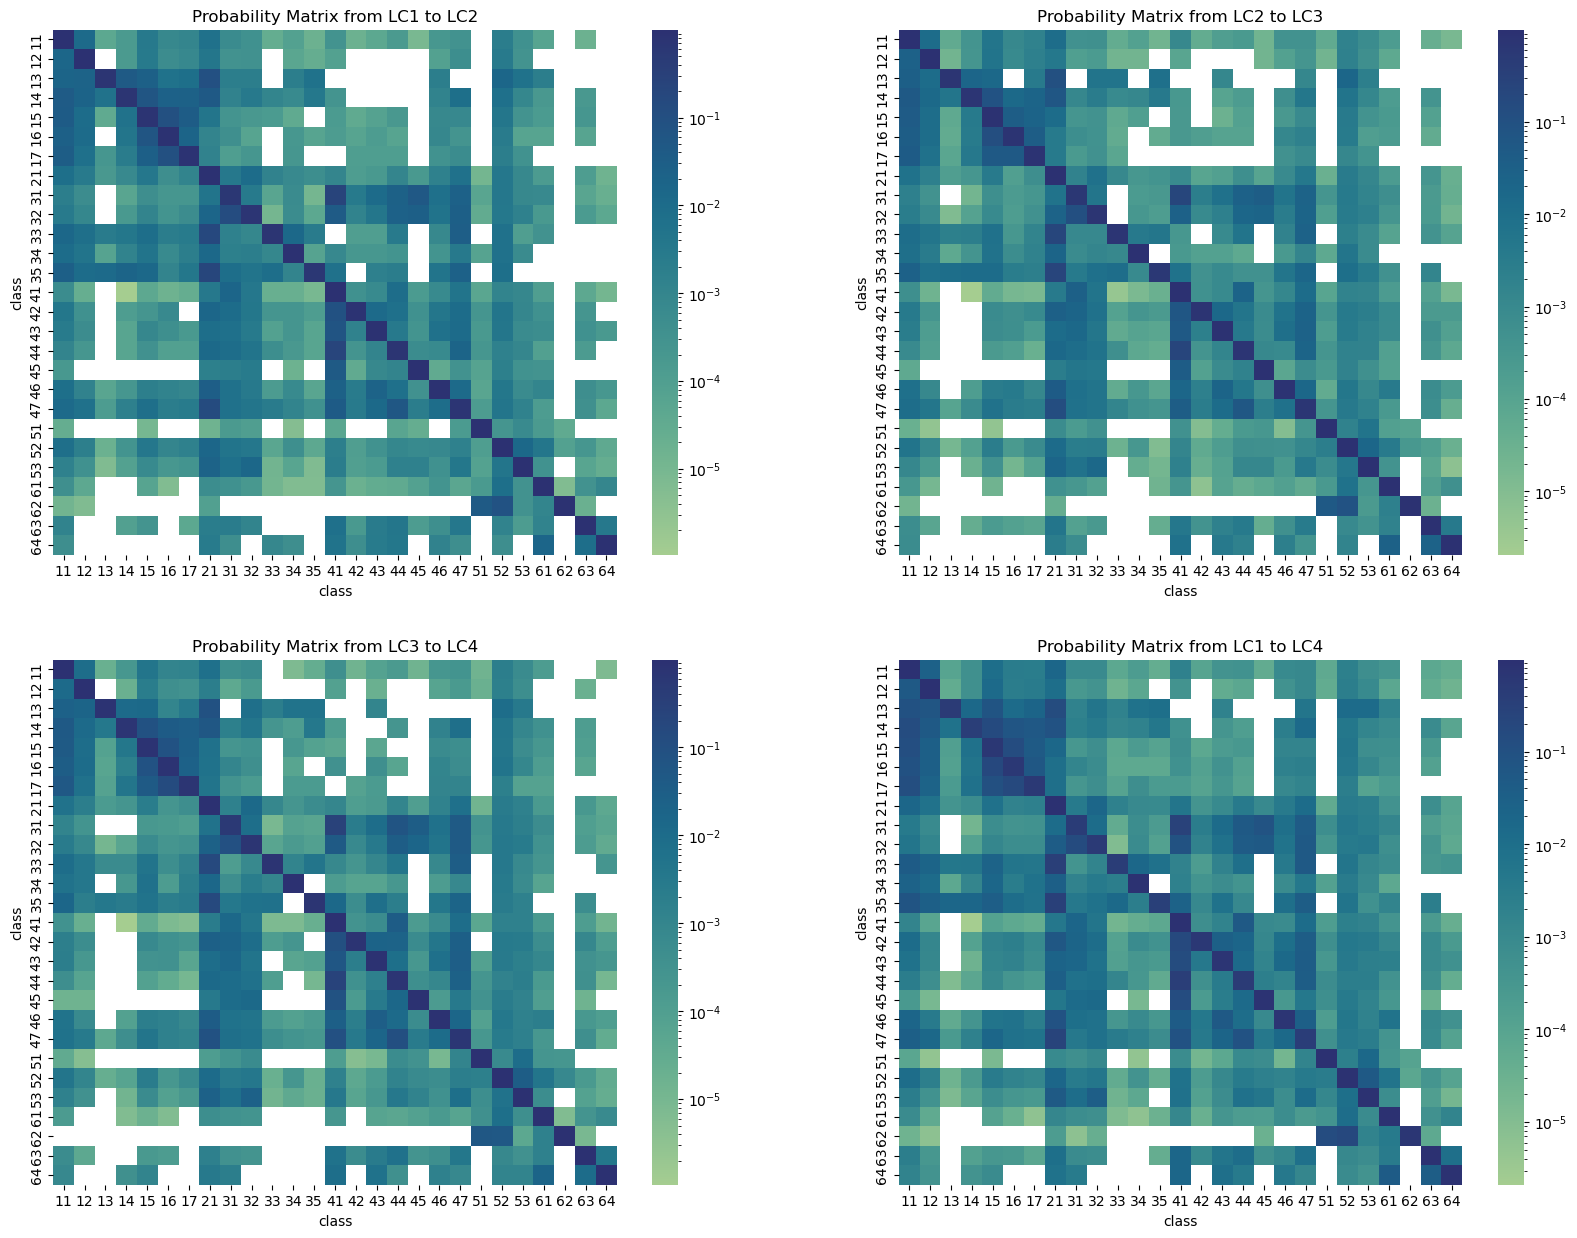

In [268]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
sns.heatmap(proba_mat_df_ls[0], cmap="crest", norm=LogNorm(), ax=ax[0,0])
ax[0,0].set_title('Probability Matrix from LC1 to LC2')
ax[0,0].set_xlabel('class')
ax[0,0].set_ylabel('class')

sns.heatmap(proba_mat_df_ls[1], cmap="crest", norm=LogNorm(), ax=ax[0,1])
ax[0,1].set_title('Probability Matrix from LC2 to LC3')
ax[0,1].set_xlabel('class')
ax[0,1].set_ylabel('class')

sns.heatmap(proba_mat_df_ls[2], cmap="crest", norm=LogNorm(), ax=ax[1,0])
ax[1,0].set_title('Probability Matrix from LC3 to LC4')
ax[1,0].set_xlabel('class')
ax[1,0].set_ylabel('class')

sns.heatmap(proba_mat_df_ls[3], cmap="crest", norm=LogNorm(), ax=ax[1,1])
ax[1,1].set_title('Probability Matrix from LC1 to LC4')
ax[1,1].set_xlabel('class')
ax[1,1].set_ylabel('class')
# plt.savefig('LC_proba_matrix.png', dpi=200)
plt.show()

## Land Use

In [410]:
data_use.head()

,LU4,LU3,LU2,LU1
RELI,,,,
74222228,242,242,242,242
76582227,301,301,301,301
72042228,222,222,222,222
74632226,421,421,421,421
75392541,301,301,301,301


In [411]:
df_LU1_2 = data_use.groupby(['LU1', 'LU2'])['LU3'].count()
df_LU2_3 = data_use.groupby(['LU2', 'LU3'])['LU4'].count()
df_LU3_4 = data_use.groupby(['LU3', 'LU4'])['LU1'].count()
df_LU1_4 = data_use.groupby(['LU1', 'LU4'])['LU2'].count()

In [412]:
sum_LU1 = data_use.groupby('LU1')['LU2'].count()
sum_LU2 = data_use.groupby('LU2')['LU3'].count()
sum_LU3 = data_use.groupby('LU3')['LU4'].count()

In [413]:
survey_ls = [[sum_LU1, df_LU1_2], [sum_LU2, df_LU2_3], [sum_LU3, df_LU3_4],[sum_LU1, df_LU1_4]]
proba_mat_df_ls = []
for s, df in survey_ls:
    sum_survey = s
    df_survey = df
    proba_mat = []
    for row in sum_survey.index.values:
        proba_row = []
        for col in sum_survey.index.values:
            if (row, col) in df_survey.index:
                proba_row.append(df_survey.loc[(row, col)] / sum_survey[row]) 
            else:
                proba_row.append(0)
        proba_mat.append(proba_row)
    proba_mat_df_ls.append(pd.DataFrame(proba_mat, columns=sum_survey.index.values, index=sum_survey.index.values))

In [414]:
proba_mat_df_ls[0].head()

,101,102,103,104,105,106,107,108,121,122,...,302,303,304,401,402,403,421,422,423,424
101,0.949063,0.001576,0.000083,0.000664,0.002904,0.000830,0.000000,0.005144,0.000083,0.002323,...,0.000083,0.0,0.0,0.0,0.000083,0.0,0.000000,0.0,0.0,0.000083
102,0.112243,0.818659,0.003343,0.001433,0.011622,0.002070,0.000478,0.008916,0.000000,0.003025,...,0.000159,0.0,0.0,0.0,0.000318,0.0,0.000478,0.0,0.0,0.000000
103,0.000237,0.000513,0.985110,0.000948,0.005826,0.000573,0.000079,0.001995,0.000000,0.001047,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000020,0.0,0.0,0.000000
104,0.000000,0.000000,0.000000,0.996472,0.001512,0.000000,0.000000,0.000000,0.000000,0.000504,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
105,0.000265,0.000477,0.000371,0.000106,0.992692,0.000212,0.000053,0.001483,0.000000,0.001059,...,0.000000,0.0,0.0,0.0,0.000053,0.0,0.000000,0.0,0.0,0.000000


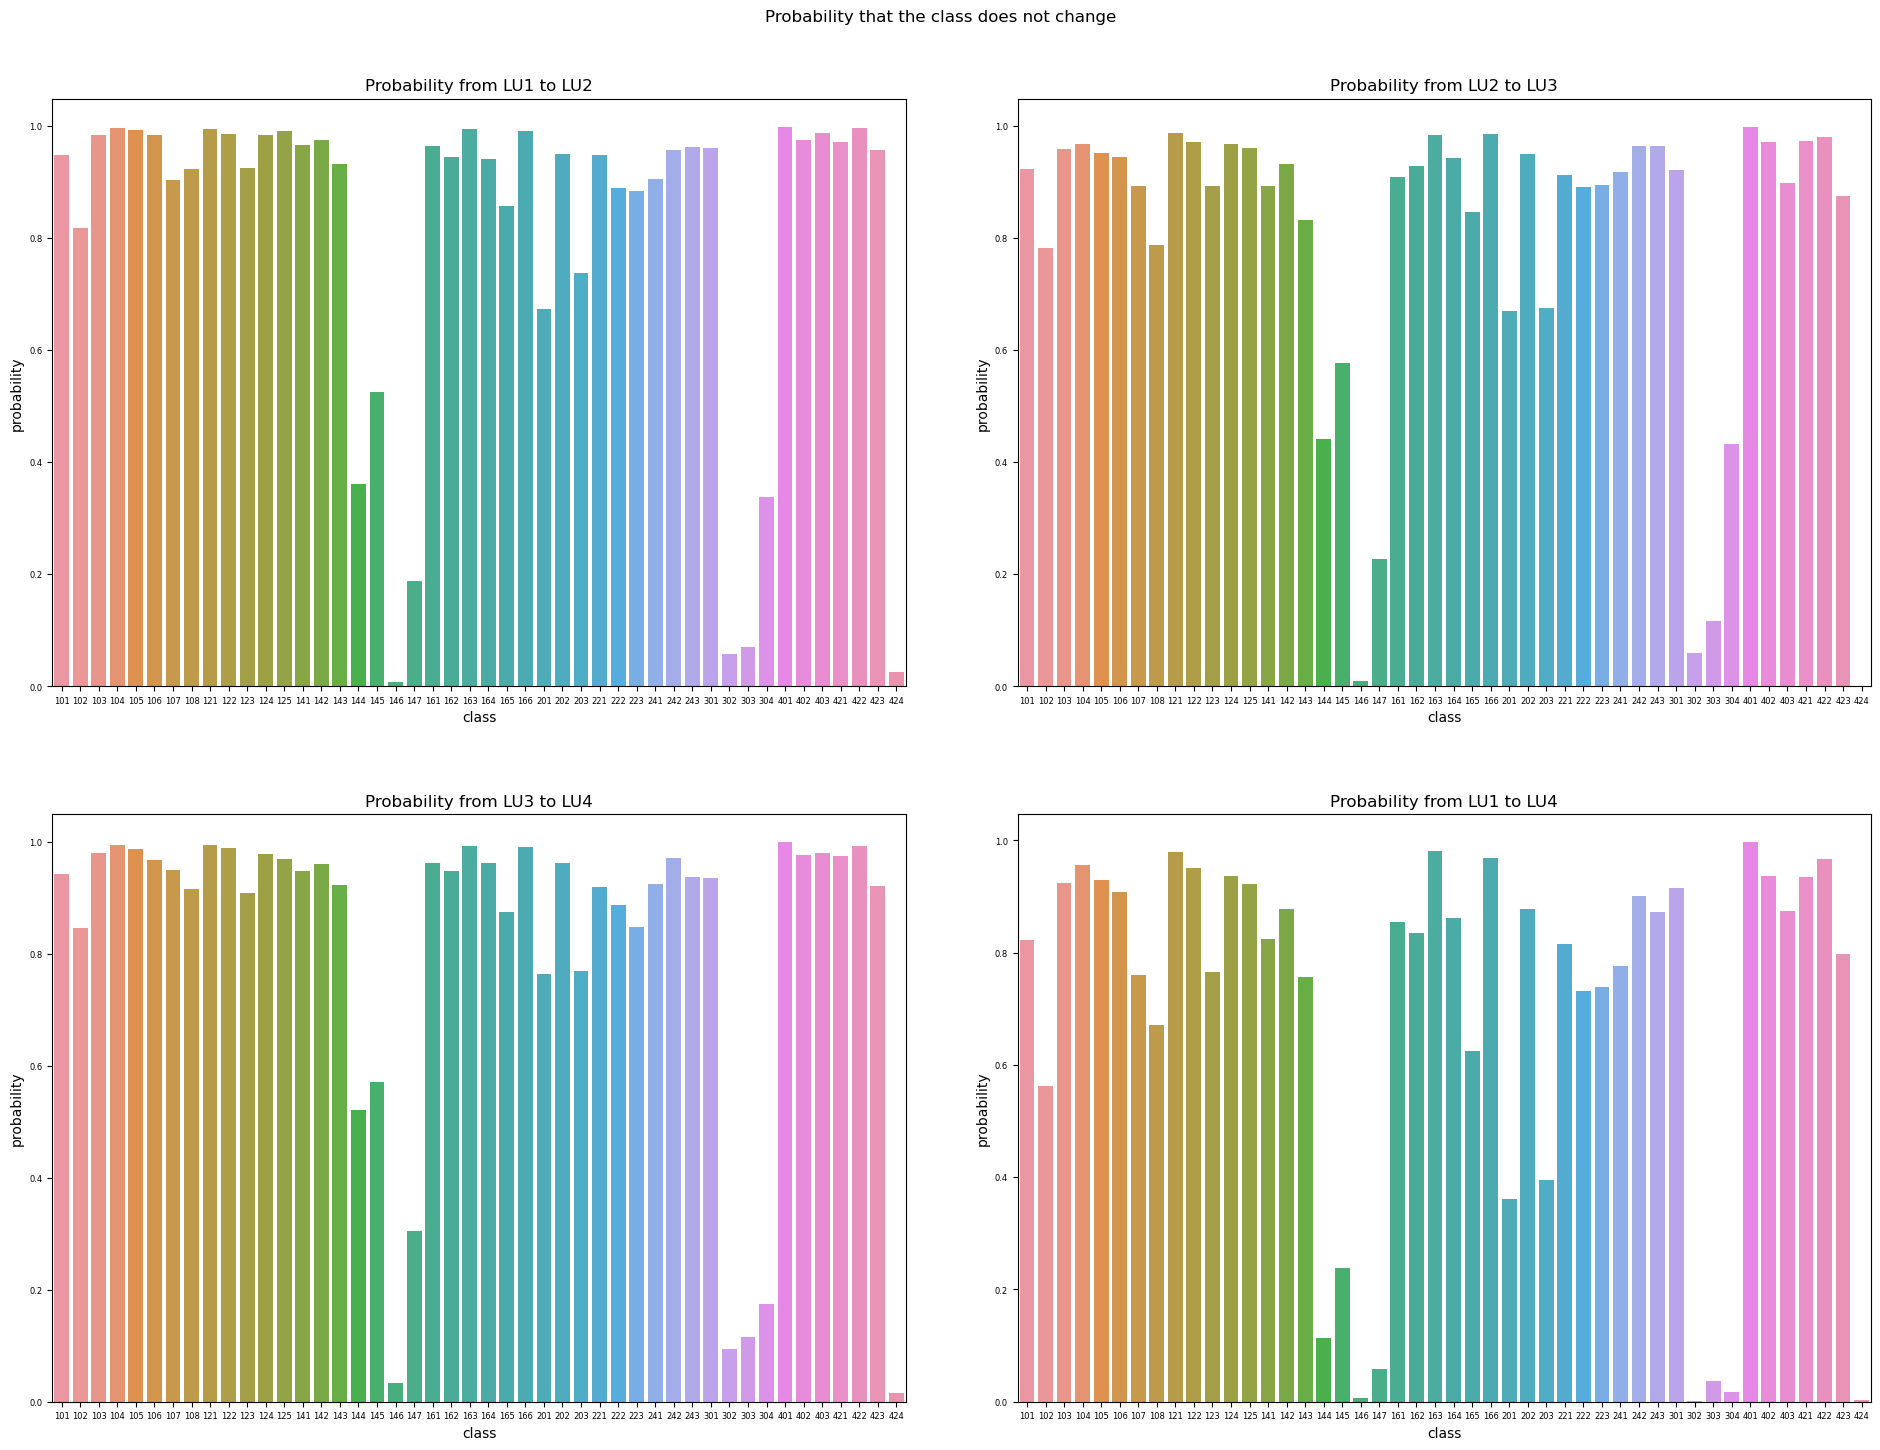

In [416]:
matplotlib.rc('xtick', labelsize = 6)

fig, ax = plt.subplots(2,2, figsize=(20,15))
# plt.xticks(fontsize=6)
sns.barplot(x=proba_mat_df_ls[0].index, y=np.diagonal(proba_mat_df_ls[0]), ax=ax[0,0])
ax[0,0].set_title('Probability from LU1 to LU2')
ax[0,0].set_xlabel('class')
ax[0,0].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls[1].index, y=np.diagonal(proba_mat_df_ls[1]), ax=ax[0,1])
ax[0,1].set_title('Probability from LU2 to LU3')
ax[0,1].set_xlabel('class')
ax[0,1].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls[2].index, y=np.diagonal(proba_mat_df_ls[2]), ax=ax[1,0])
ax[1,0].set_title('Probability from LU3 to LU4')
ax[1,0].set_xlabel('class')
ax[1,0].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls[3].index, y=np.diagonal(proba_mat_df_ls[3]), ax=ax[1,1])
ax[1,1].set_title('Probability from LU1 to LU4')
ax[1,1].set_xlabel('class')
ax[1,1].set_ylabel('probability')

plt.tick_params(axis='x', which='both', labelsize=6)
fig.tight_layout(pad=5)
fig.suptitle("Probability that the class does not change",x=0.5,y=1)
plt.savefig('LU_proba_not_change.png', dpi=200)
plt.show()

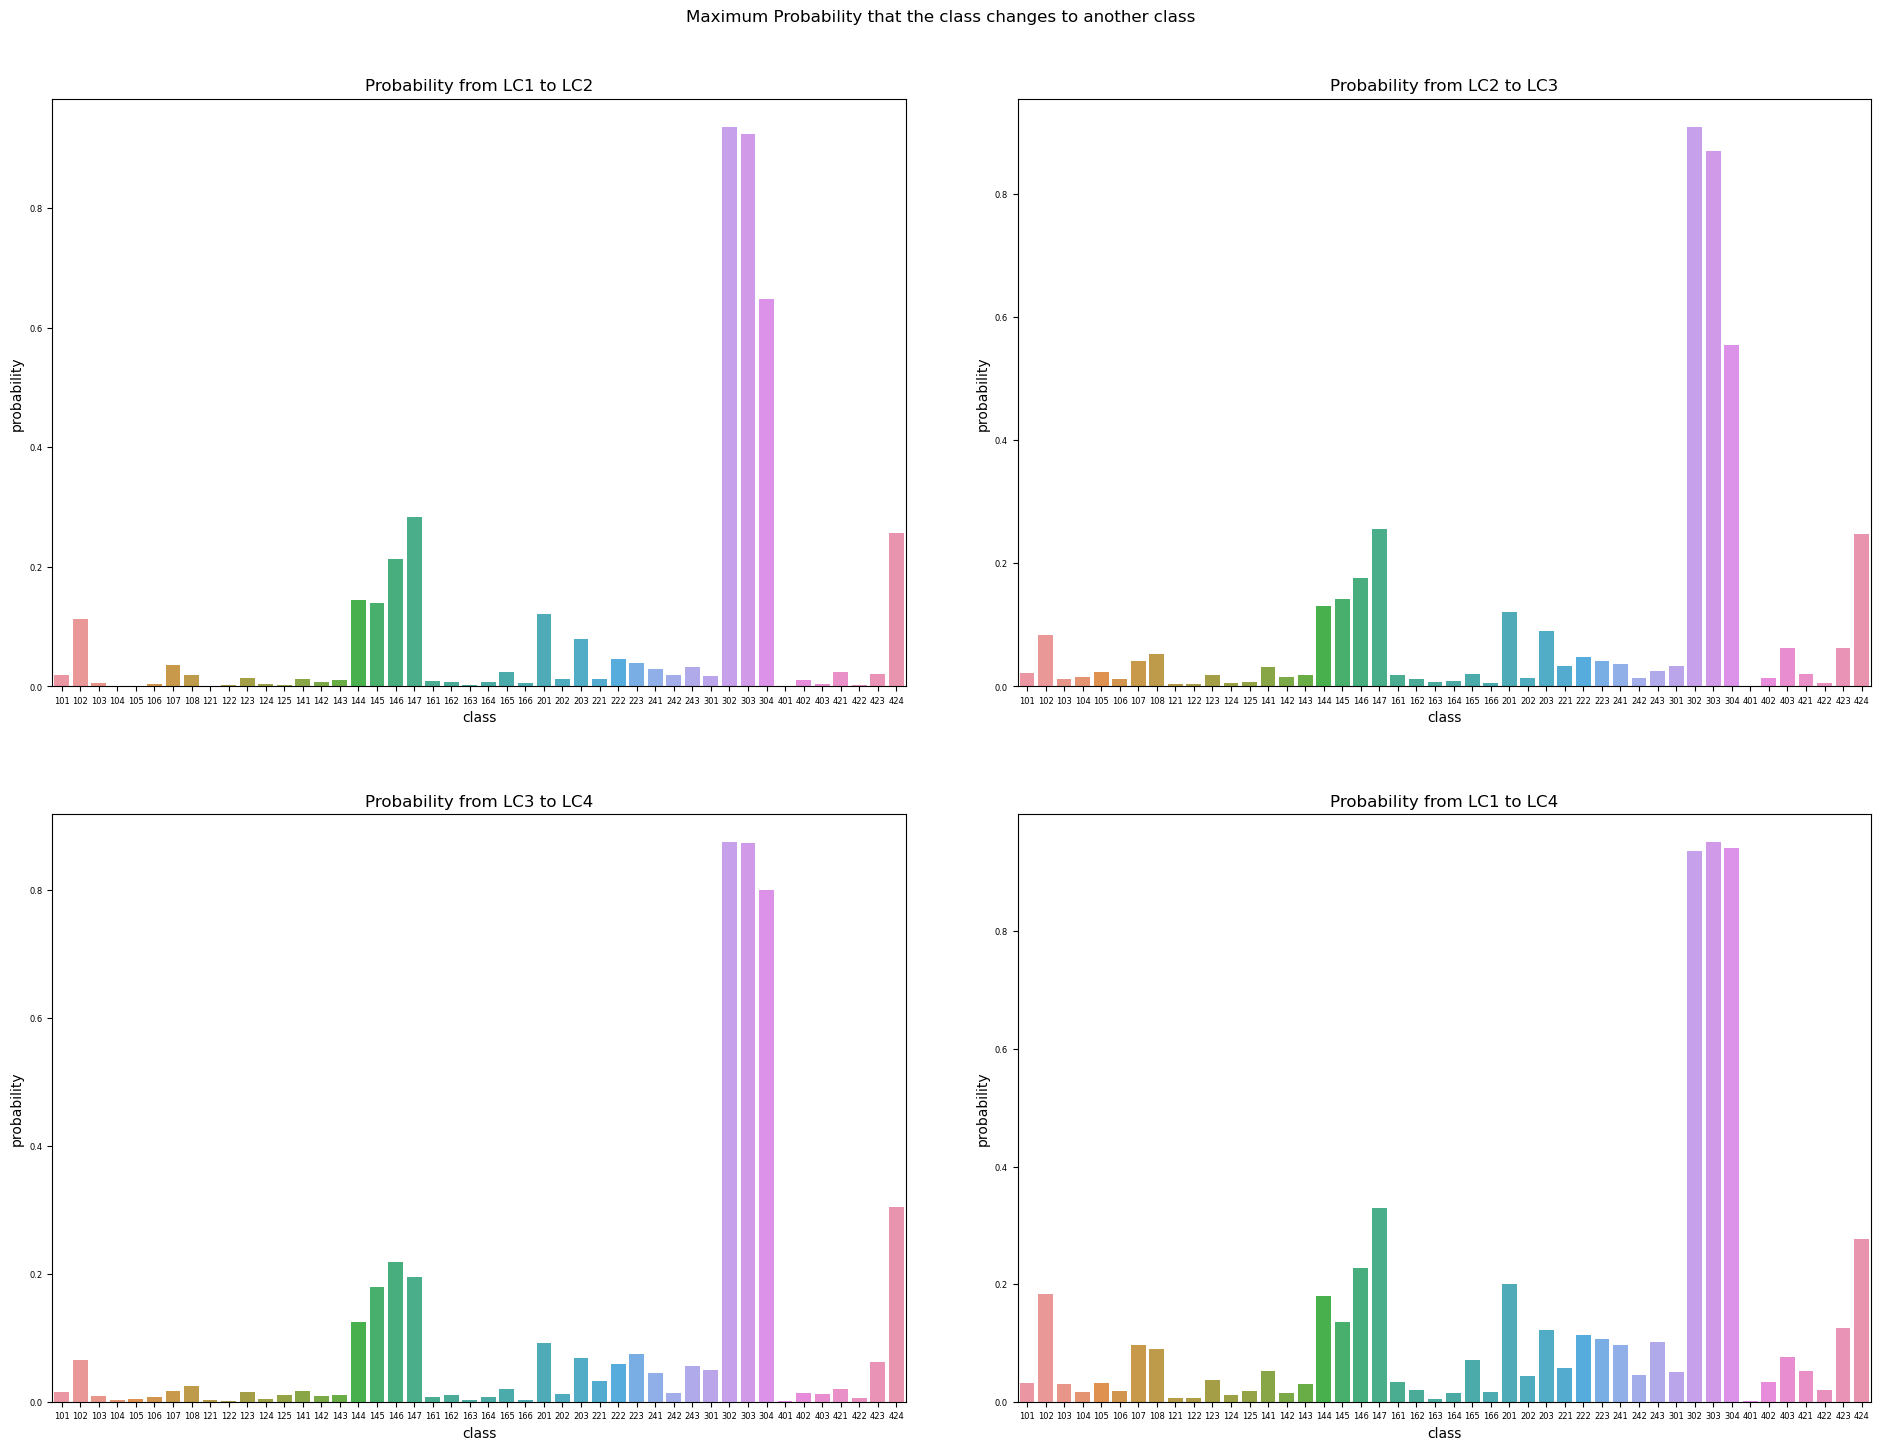

In [417]:
proba_mat_df_ls_copy = copy.deepcopy(proba_mat_df_ls)
np.fill_diagonal(proba_mat_df_ls_copy[0].values, 0)
np.fill_diagonal(proba_mat_df_ls_copy[1].values, 0)
np.fill_diagonal(proba_mat_df_ls_copy[2].values, 0)
np.fill_diagonal(proba_mat_df_ls_copy[3].values, 0)


fig, ax = plt.subplots(2,2, figsize=(20,15))
sns.barplot(x=proba_mat_df_ls_copy[0].max(axis=1).index, y=proba_mat_df_ls_copy[0].max(axis=1).values, ax=ax[0,0])
ax[0,0].set_title('Probability from LC1 to LC2')
ax[0,0].set_xlabel('class')
ax[0,0].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls_copy[1].max(axis=1).index, y=proba_mat_df_ls_copy[1].max(axis=1).values, ax=ax[0,1])
ax[0,1].set_title('Probability from LC2 to LC3')
ax[0,1].set_xlabel('class')
ax[0,1].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls_copy[2].max(axis=1).index, y=proba_mat_df_ls_copy[2].max(axis=1).values, ax=ax[1,0])
ax[1,0].set_title('Probability from LC3 to LC4')
ax[1,0].set_xlabel('class')
ax[1,0].set_ylabel('probability')

sns.barplot(x=proba_mat_df_ls_copy[3].max(axis=1).index, y=proba_mat_df_ls_copy[3].max(axis=1).values, ax=ax[1,1])
ax[1,1].set_title('Probability from LC1 to LC4')
ax[1,1].set_xlabel('class')
ax[1,1].set_ylabel('probability')
# plt.savefig('LC_proba_matrix.png', dpi=200)
fig.tight_layout(pad=5)
fig.suptitle("Maximum Probability that the class changes to another class",x=0.5,y=1)
plt.savefig('LU_proba_change.png', dpi=200)
plt.show()

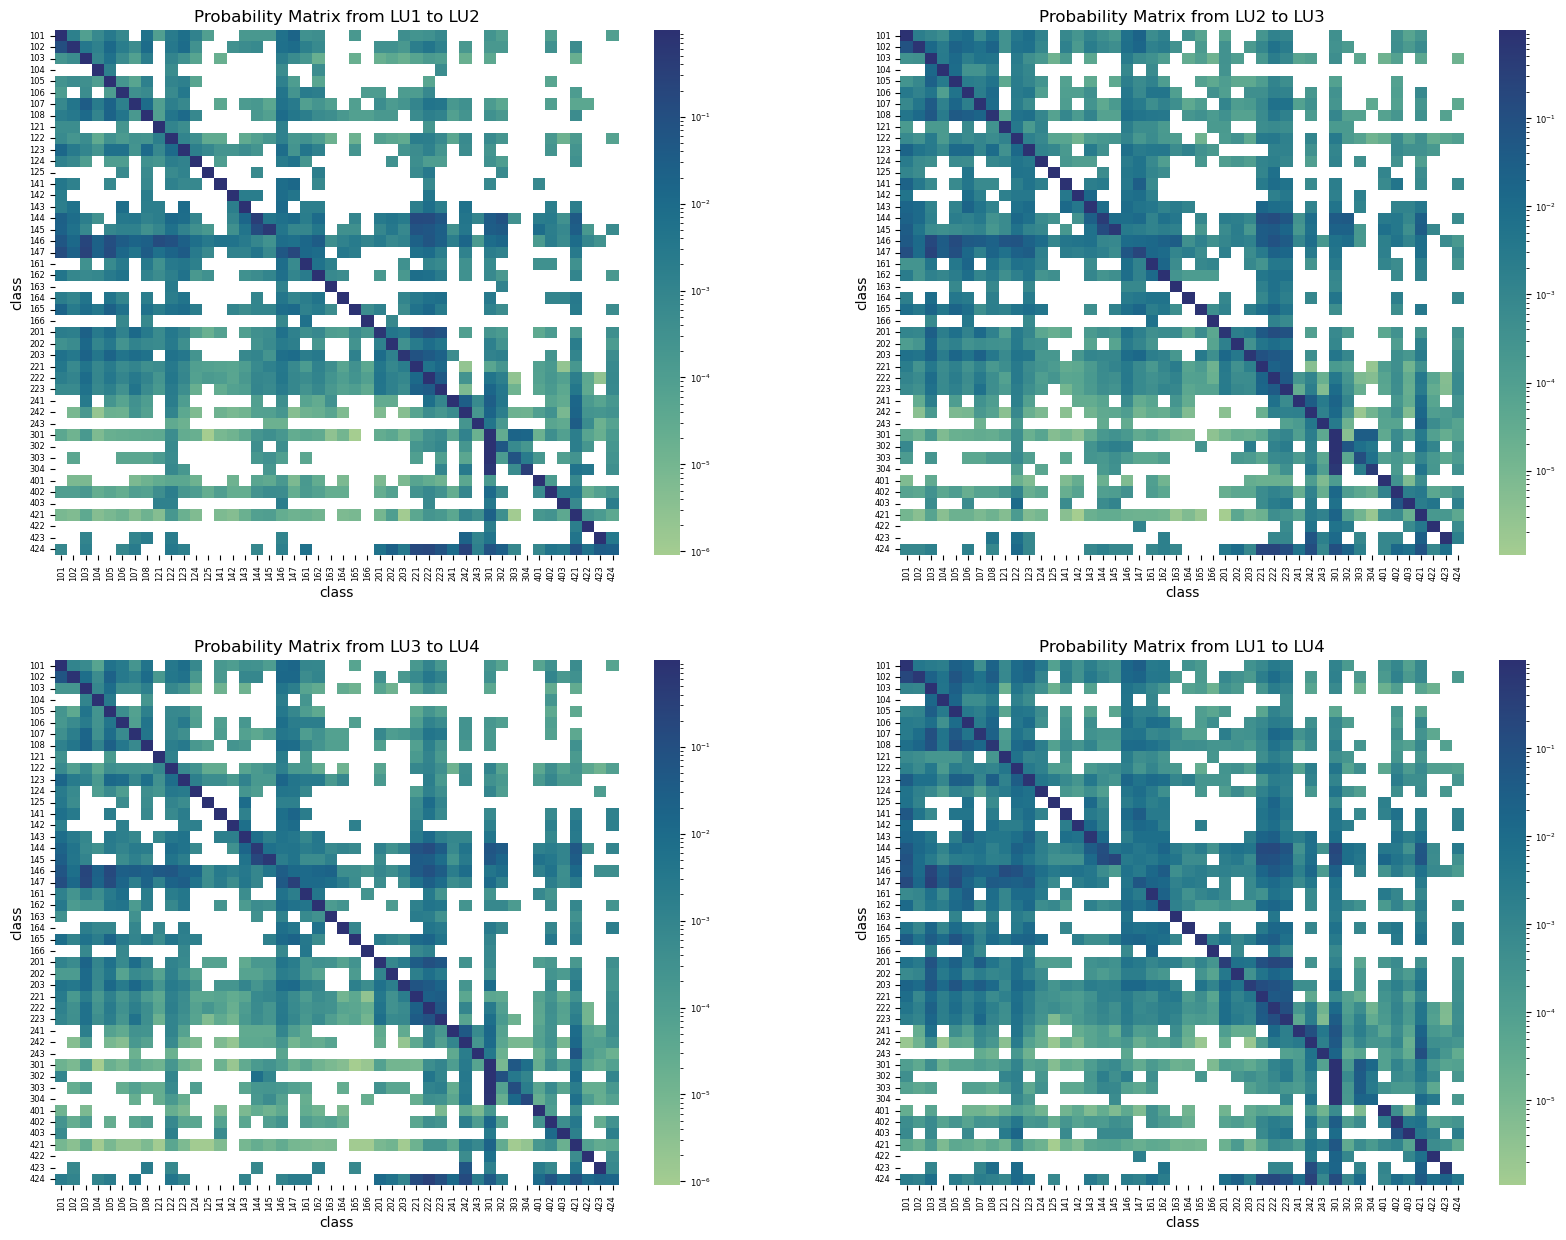

In [418]:
matplotlib.rc('ytick', labelsize = 6)

fig, ax = plt.subplots(2,2, figsize=(20,15))
sns.heatmap(proba_mat_df_ls[0], cmap="crest", norm=LogNorm(), ax=ax[0,0])
ax[0,0].set_title('Probability Matrix from LU1 to LU2')
ax[0,0].set_xlabel('class')
ax[0,0].set_ylabel('class')

sns.heatmap(proba_mat_df_ls[1], cmap="crest", norm=LogNorm(), ax=ax[0,1])
ax[0,1].set_title('Probability Matrix from LU2 to LU3')
ax[0,1].set_xlabel('class')
ax[0,1].set_ylabel('class')

sns.heatmap(proba_mat_df_ls[2], cmap="crest", norm=LogNorm(), ax=ax[1,0])
ax[1,0].set_title('Probability Matrix from LU3 to LU4')
ax[1,0].set_xlabel('class')
ax[1,0].set_ylabel('class')

sns.heatmap(proba_mat_df_ls[3], cmap="crest", norm=LogNorm(), ax=ax[1,1])
ax[1,1].set_title('Probability Matrix from LU1 to LU4')
ax[1,1].set_xlabel('class')
ax[1,1].set_ylabel('class')
plt.savefig('LU_proba_matrix.png', dpi=200)
plt.show()

# Sequence Change analysis

## Land Cover

In [12]:
# extract flag of changed tiles 
flag_rev = (data_cover.LC1 == data_cover.LC2) & (data_cover.LC2 == data_cover.LC3) & (data_cover.LC3 == data_cover.LC4)
flag = ~flag_rev
flag

RELI
74222228    False
76582227    False
72042228    False
74632226    False
75392541    False
            ...  
77571583     True
78241584    False
76401757    False
72441756    False
77951740    False
Length: 4163496, dtype: bool

In [13]:
data_cover_seq = data_cover[flag]
data_cover_seq.LC1 = data_cover_seq.LC1.astype('int')
data_cover_seq.LC2 = data_cover_seq.LC2.astype('int')
data_cover_seq.LC3 = data_cover_seq.LC3.astype('int')
data_cover_seq.LC4 = data_cover_seq.LC4.astype('int') 

In [14]:
data_cover_seq['seq'] = [(row.LC1, row.LC2, row.LC3, row.LC4) for ind, row in data_cover_seq.iterrows()]

In [15]:
data_cover_seq

,LC4,LC3,LC2,LC1,seq
RELI,,,,,
73822628,21,53,42,42,"(42, 42, 53, 21)"
71952625,41,43,43,43,"(43, 43, 43, 41)"
76082619,64,64,63,63,"(63, 63, 64, 64)"
73362617,21,21,21,47,"(47, 21, 21, 21)"
74212617,44,44,44,21,"(21, 44, 44, 44)"
...,...,...,...,...,...
64832207,41,31,41,41,"(41, 41, 31, 41)"
66652208,33,33,33,21,"(21, 33, 33, 33)"
70491297,21,47,47,21,"(21, 47, 47, 21)"


In [16]:
data_cover_filter = data_cover_seq.groupby('seq').count()['LC1'].rename({'LC1':'count'})

In [17]:
data_cover_filter[data_cover_filter>1000].sort_values(ascending=False)

seq
(41, 41, 41, 44)    31014
(41, 41, 31, 41)    23510
(31, 41, 41, 41)    21311
(44, 41, 41, 41)    17446
(21, 21, 21, 32)    15901
                    ...  
(21, 47, 21, 21)     1045
(46, 46, 21, 21)     1041
(12, 12, 11, 11)     1034
(47, 47, 41, 41)     1019
(15, 15, 11, 11)     1010
Name: LC1, Length: 118, dtype: int64

In [18]:
filter_ind = data_cover_filter[data_cover_filter>1000].index
data_cover_fitered = data_cover_seq[[True if seq in filter_ind else False for seq in data_cover_seq.seq]]
data_cover_fitered

,LC4,LC3,LC2,LC1,seq
RELI,,,,,
71952625,41,43,43,43,"(43, 43, 43, 41)"
73362617,21,21,21,47,"(47, 21, 21, 21)"
75122628,21,21,33,33,"(33, 33, 21, 21)"
75212620,21,21,21,47,"(47, 21, 21, 21)"
72952617,21,21,47,47,"(47, 47, 21, 21)"
...,...,...,...,...,...
68492206,47,21,21,21,"(21, 21, 21, 47)"
75591757,44,47,47,47,"(47, 47, 47, 44)"
64832207,41,31,41,41,"(41, 41, 31, 41)"


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Create dimensions
survey_1 = go.parcats.Dimension(
    values=data_cover_fitered.LC1,
    categoryorder='category ascending',
    label="1985"
)

survey_2 = go.parcats.Dimension(
    values=data_cover_fitered.LC2,
    categoryorder='category ascending',
    label="1997"
)


survey_3 = go.parcats.Dimension(
    values=data_cover_fitered.LC3,
    categoryorder='category ascending',
    label="2009"
)

survey_4 = go.parcats.Dimension(
    values=data_cover_fitered.LC4, 
    categoryorder='category ascending',
    label="2018"
)

# Create parcats trace
color = data_cover_fitered.LC4 / 62
# color = [1 if row.LC1 == 41 else 0 for ind, row in data_cover_fitered.iterrows()]
color_ls = ['yellowgreen', 'antiquewhite', 'azure',
            'beige', 'bisque', 'blanchedalmond',
            'blueviolet', 'brown', 'burlywood', 'cadetblue',
            'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
            'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
            'dimgray', 'dimgrey', 'dodgerblue', 'firebrick',
            'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
            'ghostwhite', 'gold', 'goldenrod', 'gray', 'grey', 'green',
            'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo',
            'yellow']

classes = np.unique(pd.concat([data_cover_fitered.LC1, data_cover_fitered.LC2, data_cover_fitered.LC3, data_cover_fitered.LC4])) / 62
colorscale = [[ind, clr] for ind, clr in zip(classes, color_ls[:len(classes)])]
# colorscale = color_ls[:len(color)]

# colorscale = [[0, 'lightsteelblue'], [1, 'mediumseagreen']]

fig = go.Figure(data = [go.Parcats(dimensions=[survey_1, survey_2, survey_3, survey_4],
        line={'color': color, 'colorscale': colorscale},
        # line={'color': np.unique(data_cover_fitered.LC1).astype('int')},
        hoveron='color', hoverinfo='count',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
        arrangement='freeform')])

fig.update_layout(
    autosize=False,
    width=1500,
    height=1000
)

fig.show()

In [20]:
fig.write_html("papa_cat_lc.html")

## Land Use

In [ ]:
flag_rev = (data_use.LU1 == data_use.LU2) & (data_use.LU2 == data_use.LU3) & (data_use.LU3 == data_use.LU4)
flag = ~flag_rev
flag

In [ ]:
data_use_seq = data_use[flag]
data_use_seq.LU1 = data_use_seq.LU1.astype('int')
data_use_seq.LU2 = data_use_seq.LU2.astype('int')
data_use_seq.LU3 = data_use_seq.LU3.astype('int')
data_use_seq.LU4 = data_use_seq.LU4.astype('int') 

In [ ]:
data_use_seq['seq'] = [(row.LU1, row.LU2, row.LU3, row.LU4) for ind, row in data_use_seq.iterrows()]

In [ ]:
data_use_seq

In [16]:
data_use_filter = data_use_seq.groupby('seq').count()['LU1'].rename({'LU1':'count'})

In [17]:
data_use_filter[data_use_filter>1000].sort_values(ascending=False)

seq
(301, 301, 301, 303)    50400
(301, 301, 303, 301)    32186
(301, 301, 304, 301)    29989
(421, 301, 301, 301)    20070
(303, 301, 301, 301)    19452
                        ...  
(301, 304, 304, 304)     1063
(421, 421, 421, 242)     1059
(222, 222, 222, 201)     1018
(221, 105, 105, 105)     1012
(222, 222, 421, 421)     1011
Name: LU1, Length: 92, dtype: int64

In [18]:
filter_ind = data_use_filter[data_use_filter>1000].index
data_use_fitered = data_use_seq[[True if seq in filter_ind else False for seq in data_use_seq.seq]]
data_use_fitered

,LU4,LU3,LU2,LU1,seq
RELI,,,,,
73032623,223,223,222,222,"(222, 222, 223, 223)"
75122628,221,221,201,201,"(201, 201, 221, 221)"
75212620,222,222,222,201,"(201, 222, 222, 222)"
75262615,221,221,221,222,"(222, 221, 221, 221)"
72952617,222,222,201,201,"(201, 201, 222, 222)"
...,...,...,...,...,...
75591757,301,421,421,421,"(421, 421, 421, 301)"
64832207,301,304,301,301,"(301, 301, 304, 301)"
72002362,222,223,223,223,"(223, 223, 223, 222)"


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Create dimensions
survey_1 = go.parcats.Dimension(
    values=data_use_fitered.LU1,
    categoryorder='category ascending',
    label="1985"
)

survey_2 = go.parcats.Dimension(
    values=data_use_fitered.LU2,
    categoryorder='category ascending',
    label="1997"
)


survey_3 = go.parcats.Dimension(
    values=data_use_fitered.LU3,
    categoryorder='category ascending',
    label="2009"
)

survey_4 = go.parcats.Dimension(
    values=data_use_fitered.LU4, 
    categoryorder='category ascending',
    label="2018"
)

# Create parcats trace
color = data_use_fitered.LU4 / 424
# color = [1 if row.LC1 == 41 else 0 for ind, row in data_cover_fitered.iterrows()]
color_ls = ['antiquewhite', 'azure',
            'beige', 'bisque', 'blanchedalmond',
            'blueviolet', 'brown', 'burlywood', 'cadetblue',
            'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
            'cornsilk', 'crimson', 'cyan', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
            'dimgray', 'dimgrey', 'dodgerblue', 'firebrick',
            'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
            'ghostwhite', 'gold', 'goldenrod', 'gray', 'grey', 'green',
            'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo',
            'yellow']

classes = np.unique(pd.concat([data_use_fitered.LU1, data_use_fitered.LU2, data_use_fitered.LU3, data_use_fitered.LU4])) / 424
colorscale = [[ind, clr] for ind, clr in zip(classes, color_ls[:len(classes)])]
# colorscale = color_ls[:len(color)]

# colorscale = [[0, 'lightsteelblue'], [1, 'mediumseagreen']]

fig = go.Figure(data = [go.Parcats(dimensions=[survey_1, survey_2, survey_3, survey_4],
        line={'color': color, 'colorscale': colorscale},
        # line={'color': np.unique(data_cover_fitered.LC1).astype('int')},
        hoveron='color', hoverinfo='count',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
        arrangement='freeform')])

fig.update_layout(
    autosize=False,
    width=1500,
    height=1000
)

fig.show()

In [23]:
colorscale

[[0.23820754716981132, 'antiquewhite'],
 [0.2429245283018868, 'azure'],
 [0.24764150943396226, 'beige'],
 [0.25235849056603776, 'bisque'],
 [0.28773584905660377, 'blanchedalmond'],
 [0.3443396226415094, 'blueviolet'],
 [0.4740566037735849, 'brown'],
 [0.5212264150943396, 'burlywood'],
 [0.5235849056603774, 'cadetblue'],
 [0.5259433962264151, 'chartreuse'],
 [0.5683962264150944, 'chocolate'],
 [0.5707547169811321, 'coral'],
 [0.5731132075471698, 'cornflowerblue'],
 [0.7099056603773585, 'cornsilk'],
 [0.7122641509433962, 'crimson'],
 [0.714622641509434, 'cyan'],
 [0.7169811320754716, 'darkblue'],
 [0.9929245283018868, 'darkcyan']]